<a href="https://colab.research.google.com/github/Aadi11-crypto/WORKBOOK/blob/main/CSD456_Lab06_LeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 94.4 MB/s eta 0:00:00


## LeNet

At a high level, (**LeNet (LeNet-5) consists of two parts:
(i) a convolutional encoder consisting of two convolutional layers; and
(ii) a dense block consisting of three fully connected layers**).
The architecture is summarized in :numref:`img_lenet`.

![Data flow in LeNet. The input is a handwritten digit, the output is a probability over 10 possible outcomes.](http://d2l.ai/_images/lenet.svg)
:label:`img_lenet`

The basic units in each convolutional block
are a convolutional layer, a sigmoid activation function,
and a subsequent average pooling operation.
Note that while ReLUs and max-pooling work better,
they had not yet been discovered.
Each convolutional layer uses a $5\times 5$ kernel
and a sigmoid activation function.
These layers map spatially arranged inputs
to a number of two-dimensional feature maps, typically
increasing the number of channels.
The first convolutional layer has 6 output channels,
while the second has 16.
Each $2\times2$ pooling operation (stride 2)
reduces dimensionality by a factor of $4$ via spatial downsampling.
The convolutional block emits an output with shape given by
(batch size, number of channel, height, width).

In order to pass output from the convolutional block
to the dense block,
we must flatten each example in the minibatch.
In other words, we take this four-dimensional input and transform it
into the two-dimensional input expected by fully connected layers:
as a reminder, the two-dimensional representation that we desire uses the first dimension to index examples in the minibatch
and the second to give the flat vector representation of each example.
LeNet's dense block has three fully connected layers,
with 120, 84, and 10 outputs, respectively.
Because we are still performing classification,
the 10-dimensional output layer corresponds
to the number of possible output classes.

While getting to the point where you truly understand
what is going on inside LeNet may have taken a bit of work,
we hope that the following code snippet will convince you
that implementing such models with modern deep learning frameworks
is remarkably simple.
We need only to instantiate a `Sequential` block
and chain together the appropriate layers,
using Xavier initialization as
introduced in :numref:`subsec_xavier`.

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
from collections import OrderedDict

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
class C1(nn.Module):
    def __init__(self):
        super(C1, self).__init__()

        self.c1 = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(1, 6, kernel_size=(5, 5))),
            ('relu1', nn.ReLU()),
            ('s1', nn.AvgPool2d(kernel_size=(2, 2), stride=2))
        ]))

    def forward(self, img):
        output = self.c1(img)
        return output

In [6]:
class C2(nn.Module):
    def __init__(self):
        super(C2, self).__init__()

        self.c2 = nn.Sequential(OrderedDict([
            ('c2', nn.Conv2d(6, 16, kernel_size=(5, 5))),
            ('relu2', nn.ReLU()),
            ('s2', nn.AvgPool2d(kernel_size=(2, 2), stride=2))
        ]))

    def forward(self, img):
        output = self.c2(img)
        return output

In [7]:
class C3(nn.Module):
    def __init__(self):
        super(C3, self).__init__()

        self.c3 = nn.Sequential(OrderedDict([
            ('c3', nn.Conv2d(16, 120, kernel_size=(5, 5))),
            ('relu3', nn.ReLU())
        ]))

    def forward(self, img):
        output = self.c3(img)
        return output

In [8]:
class F4(nn.Module):
    def __init__(self):
        super(F4, self).__init__()

        self.f4 = nn.Sequential(OrderedDict([
            ('f4', nn.Linear(120, 84)),
            ('relu4', nn.ReLU())
        ]))

    def forward(self, img):
        output = self.f4(img)
        return output

In [9]:
class F5(nn.Module):
    def __init__(self):
        super(F5, self).__init__()

        self.f5 = nn.Sequential(OrderedDict([
            ('f5', nn.Linear(84, 10)),
            ('sig5', nn.LogSoftmax(dim=-1))
        ]))

    def forward(self, img):
        output = self.f5(img)
        return output

In [10]:
class LeNet5(nn.Module):
    """
    Input - 1x32x32
    Output - 10
    """
    def __init__(self):
        super(LeNet5, self).__init__()

        self.c1 = C1()
        self.c2 = C2()
        self.c3 = C3()
        self.f4 = F4()
        self.f5 = F5()

    def forward(self, img):
        output = self.c1(img)
        output = self.c2(output)
        output = self.c3(output)
        output = output.view(img.size(0), -1)
        output = self.f4(output)
        output = self.f5(output)
        return output

In [11]:
import torch.optim as optim
from torchvision.datasets.mnist import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import onnx

In [12]:
data_train = MNIST('./data/mnist',
                   download=True,
                   transform=transforms.Compose([
                       transforms.Resize((32, 32)),
                       transforms.ToTensor()]))
data_test = MNIST('./data/mnist',
                  train=False,
                  download=True,
                  transform=transforms.Compose([
                      transforms.Resize((32, 32)),
                      transforms.ToTensor()]))
data_train_loader = DataLoader(data_train, batch_size=256, shuffle=True, num_workers=8)
data_test_loader = DataLoader(data_test, batch_size=1024, num_workers=8)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 3670925.68it/s]


Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 134532.73it/s]


Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:07<00:00, 222812.15it/s]


Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8964954.71it/s]

Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [13]:
net = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=2e-3)

In [14]:
dict(net.named_modules())

{'': LeNet5(
   (c1): C1(
     (c1): Sequential(
       (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
       (relu1): ReLU()
       (s1): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
     )
   )
   (c2): C2(
     (c2): Sequential(
       (c2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
       (relu2): ReLU()
       (s2): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
     )
   )
   (c3): C3(
     (c3): Sequential(
       (c3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
       (relu3): ReLU()
     )
   )
   (f4): F4(
     (f4): Sequential(
       (f4): Linear(in_features=120, out_features=84, bias=True)
       (relu4): ReLU()
     )
   )
   (f5): F5(
     (f5): Sequential(
       (f5): Linear(in_features=84, out_features=10, bias=True)
       (sig5): LogSoftmax(dim=-1)
     )
   )
 ),
 'c1': C1(
   (c1): Sequential(
     (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
     (relu1): ReLU()
     (s1): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)

In [15]:
cur_batch_win = None
cur_batch_win_opts = {
    'title': 'Epoch Loss Trace',
    'xlabel': 'Batch Number',
    'ylabel': 'Loss',
    'width': 1200,
    'height': 600,
}

In [16]:
def train(epoch):
    global cur_batch_win
    net.train()
    loss_list, batch_list = [], []
    for i, (images, labels) in enumerate(data_train_loader):
        optimizer.zero_grad()

        output = net(images.to(device))

        loss = criterion(output, labels.to(device))

        loss_list.append(loss.detach().cpu().item())
        batch_list.append(i+1)

        if i % 10 == 0:
            print('Train - Epoch %d, Batch: %d, Loss: %f' % (epoch, i, loss.detach().cpu().item()))

        loss.backward()
        optimizer.step()

In [17]:
def test():
    net.eval()
    total_correct = 0
    avg_loss = 0.0
    for i, (images, labels) in enumerate(data_test_loader):
        output = net(images.to(device))
        avg_loss += criterion(output, labels.to(device)).sum()
        pred = output.detach().cpu().max(1)[1]
        total_correct += pred.eq(labels.view_as(pred)).sum()

    avg_loss /= len(data_test)
    print('Test Avg. Loss: %f, Accuracy: %f' % (avg_loss.detach().cpu().item(), float(total_correct) / len(data_test)))

In [18]:
def train_and_test(epoch):
    train(epoch)
    test()

    dummy_input = torch.randn(1, 1, 32, 32, requires_grad=True)
    torch.onnx.export(net, dummy_input.to(device), "lenet.onnx")

    onnx_model = onnx.load("lenet.onnx")
    onnx.checker.check_model(onnx_model)

#Main

In [19]:
train_and_test(epoch=1)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train - Epoch 1, Batch: 0, Loss: 2.308350
Train - Epoch 1, Batch: 10, Loss: 2.145401
Train - Epoch 1, Batch: 20, Loss: 1.114480
Train - Epoch 1, Batch: 30, Loss: 0.854030
Train - Epoch 1, Batch: 40, Loss: 0.703908
Train - Epoch 1, Batch: 50, Loss: 0.462365
Train - Epoch 1, Batch: 60, Loss: 0.523165
Train - Epoch 1, Batch: 70, Loss: 0.469219
Train - Epoch 1, Batch: 80, Loss: 0.388241
Train - Epoch 1, Batch: 90, Loss: 0.419784
Train - Epoch 1, Batch: 100, Loss: 0.330852
Train - Epoch 1, Batch: 110, Loss: 0.373931
Train - Epoch 1, Batch: 120, Loss: 0.366787
Train - Epoch 1, Batch: 130, Loss: 0.220515
Train - Epoch 1, Batch: 140, Loss: 0.287138
Train - Epoch 1, Batch: 150, Loss: 0.294710
Train - Epoch 1, Batch: 160, Loss: 0.292686
Train - Epoch 1, Batch: 170, Loss: 0.209613
Train - Epoch 1, Batch: 180, Loss: 0.262941
Train - Epoch 1, Batch: 190, Loss: 0.281165
Train - Epoch 1, Batch: 200, Loss: 0.185757
Train - Epoch 1, Batch: 210, Loss: 0.219804
Train - Epoch 1, Batch: 220, Loss: 0.194527

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Avg. Loss: 0.000166, Accuracy: 0.950000


## Exercises

1. Let's modernize LeNet. Implement and test the following changes:[1 Mark]
    1. Replace average pooling with max-pooling.
    1. Replace the softmax layer with ReLU.

In [20]:
import torch
from torch import nn
from torch.nn import functional as F
from collections import OrderedDict
import torch.optim as optim
from torchvision.datasets.mnist import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import onnx

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Updated Convolutional Layers (Replacing AvgPool with MaxPool)
class C1(nn.Module):
    def __init__(self):
        super(C1, self).__init__()
        self.c1 = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(1, 6, kernel_size=(5, 5))),
            ('relu1', nn.ReLU()),
            ('s1', nn.MaxPool2d(kernel_size=(2, 2), stride=2))  # Max Pooling
        ]))

    def forward(self, img):
        output = self.c1(img)
        return output

class C2(nn.Module):
    def __init__(self):
        super(C2, self).__init__()
        self.c2 = nn.Sequential(OrderedDict([
            ('c2', nn.Conv2d(6, 16, kernel_size=(5, 5))),
            ('relu2', nn.ReLU()),
            ('s2', nn.MaxPool2d(kernel_size=(2, 2), stride=2))  # Max Pooling
        ]))

    def forward(self, img):
        output = self.c2(img)
        return output

class C3(nn.Module):
    def __init__(self):
        super(C3, self).__init__()
        self.c3 = nn.Sequential(OrderedDict([
            ('c3', nn.Conv2d(16, 120, kernel_size=(5, 5))),
            ('relu3', nn.ReLU())
        ]))

    def forward(self, img):
        output = self.c3(img)
        return output

# Updated Fully Connected Layers (Replacing LogSoftmax with ReLU in F5)
class F4(nn.Module):
    def __init__(self):
        super(F4, self).__init__()
        self.f4 = nn.Sequential(OrderedDict([
            ('f4', nn.Linear(120, 84)),
            ('relu4', nn.ReLU())
        ]))

    def forward(self, img):
        output = self.f4(img)
        return output

class F5(nn.Module):
    def __init__(self):
        super(F5, self).__init__()
        self.f5 = nn.Sequential(OrderedDict([
            ('f5', nn.Linear(84, 10)),
            ('relu5', nn.ReLU())  # ReLU instead of LogSoftmax
        ]))

    def forward(self, img):
        output = self.f5(img)
        return output

# Updated LeNet5 Class
class LeNet5(nn.Module):
    """
    Input - 1x32x32
    Output - 10
    """
    def __init__(self):
        super(LeNet5, self).__init__()
        self.c1 = C1()
        self.c2 = C2()
        self.c3 = C3()
        self.f4 = F4()
        self.f5 = F5()

    def forward(self, img):
        output = self.c1(img)
        output = self.c2(output)
        output = self.c3(output)
        output = output.view(img.size(0), -1)
        output = self.f4(output)
        output = self.f5(output)
        return output

# Training and Testing Code

data_train = MNIST('./data/mnist', download=True, transform=transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()]))
data_test = MNIST('./data/mnist', train=False, download=True, transform=transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()]))
data_train_loader = DataLoader(data_train, batch_size=256, shuffle=True, num_workers=8)
data_test_loader = DataLoader(data_test, batch_size=1024, num_workers=8)

net = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=2e-3)

def train(epoch):
    net.train()
    for i, (images, labels) in enumerate(data_train_loader):
        optimizer.zero_grad()
        output = net(images.to(device))
        loss = criterion(output, labels.to(device))
        if i % 10 == 0:
            print('Train - Epoch %d, Batch: %d, Loss: %f' % (epoch, i, loss.detach().cpu().item()))
        loss.backward()
        optimizer.step()

def test():
    net.eval()
    total_correct = 0
    avg_loss = 0.0
    with torch.no_grad():
        for i, (images, labels) in enumerate(data_test_loader):
            output = net(images.to(device))
            avg_loss += criterion(output, labels.to(device)).sum()
            pred = output.detach().cpu().max(1)[1]
            total_correct += pred.eq(labels.view_as(pred)).sum()

    avg_loss /= len(data_test)
    print('Test Avg. Loss: %f, Accuracy: %f' % (avg_loss.detach().cpu().item(), float(total_correct) / len(data_test)))

def train_and_test(epoch):
    train(epoch)
    test()

    # Export to ONNX for deployment
    dummy_input = torch.randn(1, 1, 32, 32, requires_grad=True)
    torch.onnx.export(net, dummy_input.to(device), "modern_lenet.onnx")
    onnx_model = onnx.load("modern_lenet.onnx")
    onnx.checker.check_model(onnx_model)

# Train and test the model for 1 epoch
train_and_test(epoch=1)


cuda


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train - Epoch 1, Batch: 0, Loss: 2.302372
Train - Epoch 1, Batch: 10, Loss: 2.112152
Train - Epoch 1, Batch: 20, Loss: 1.879495
Train - Epoch 1, Batch: 30, Loss: 1.545506
Train - Epoch 1, Batch: 40, Loss: 1.157004
Train - Epoch 1, Batch: 50, Loss: 1.165059
Train - Epoch 1, Batch: 60, Loss: 1.064205
Train - Epoch 1, Batch: 70, Loss: 1.131991
Train - Epoch 1, Batch: 80, Loss: 0.963151
Train - Epoch 1, Batch: 90, Loss: 0.948707
Train - Epoch 1, Batch: 100, Loss: 1.114407
Train - Epoch 1, Batch: 110, Loss: 0.913534
Train - Epoch 1, Batch: 120, Loss: 0.968032
Train - Epoch 1, Batch: 130, Loss: 0.920448
Train - Epoch 1, Batch: 140, Loss: 1.078539
Train - Epoch 1, Batch: 150, Loss: 1.097250
Train - Epoch 1, Batch: 160, Loss: 0.889519
Train - Epoch 1, Batch: 170, Loss: 0.859279
Train - Epoch 1, Batch: 180, Loss: 0.891937
Train - Epoch 1, Batch: 190, Loss: 0.756629
Train - Epoch 1, Batch: 200, Loss: 0.937113
Train - Epoch 1, Batch: 210, Loss: 0.713494
Train - Epoch 1, Batch: 220, Loss: 0.873889

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Avg. Loss: 0.000856, Accuracy: 0.664800


2. Try to change the size of the LeNet style network to improve its accuracy in addition to max-pooling and ReLU. [2.5 Marks]
  1. Adjust the convolution window size.
  2. Adjust the number of output channels.
  3. Adjust the number of convolution layers.
  4. Adjust the number of fully connected layers.
  5. Adjust the learning rates and other training details (e.g., initialization and number of epochs).



In [21]:
import torch
from torch import nn
from torch.nn import functional as F
from collections import OrderedDict
import torch.optim as optim
from torchvision.datasets.mnist import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import onnx

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Adjusted Convolutional Layers with More Channels and Smaller Kernel Size
class C1(nn.Module):
    def __init__(self):
        super(C1, self).__init__()
        self.c1 = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(1, 16, kernel_size=(3, 3))),  # Increase output channels from 6 to 16
            ('relu1', nn.ReLU()),
            ('s1', nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        ]))

    def forward(self, img):
        output = self.c1(img)
        return output

class C2(nn.Module):
    def __init__(self):
        super(C2, self).__init__()
        self.c2 = nn.Sequential(OrderedDict([
            ('c2', nn.Conv2d(16, 32, kernel_size=(3, 3))),  # Increase output channels from 16 to 32
            ('relu2', nn.ReLU()),
            ('s2', nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        ]))

    def forward(self, img):
        output = self.c2(img)
        return output

# Adding an Extra Convolutional Layer for Deeper Feature Extraction
class C3(nn.Module):
    def __init__(self):
        super(C3, self).__init__()
        self.c3 = nn.Sequential(OrderedDict([
            ('c3', nn.Conv2d(32, 64, kernel_size=(3, 3))),  # New convolutional layer with 64 channels
            ('relu3', nn.ReLU()),
            ('s3', nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        ]))

    def forward(self, img):
        output = self.c3(img)
        return output

# Adjusted Fully Connected Layers
class F4(nn.Module):
    def __init__(self):
        super(F4, self).__init__()
        self.f4 = nn.Sequential(OrderedDict([
            ('f4', nn.Linear(64 * 2 * 2, 120)),  # Adjust input size based on new C3 output
            ('relu4', nn.ReLU())
        ]))

    def forward(self, img):
        output = self.f4(img)
        return output

# Final Output Layer Remains Similar with ReLU
class F5(nn.Module):
    def __init__(self):
        super(F5, self).__init__()
        self.f5 = nn.Sequential(OrderedDict([
            ('f5', nn.Linear(120, 84)),
            ('relu5', nn.ReLU()),
            ('out', nn.Linear(84, 10))  # Final layer to output 10 classes
        ]))

    def forward(self, img):
        output = self.f5(img)
        return output

# Updated LeNet5 Class with New Architecture
class LeNet5_Modified(nn.Module):
    """
    Input - 1x32x32
    Output - 10
    """
    def __init__(self):
        super(LeNet5_Modified, self).__init__()
        self.c1 = C1()
        self.c2 = C2()
        self.c3 = C3()  # Added third convolutional layer
        self.f4 = F4()
        self.f5 = F5()

    def forward(self, img):
        output = self.c1(img)
        output = self.c2(output)
        output = self.c3(output)
        output = output.view(img.size(0), -1)
        output = self.f4(output)
        output = self.f5(output)
        return output

# Training and Testing

data_train = MNIST('./data/mnist', download=True, transform=transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()]))
data_test = MNIST('./data/mnist', train=False, download=True, transform=transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()]))
data_train_loader = DataLoader(data_train, batch_size=256, shuffle=True, num_workers=8)
data_test_loader = DataLoader(data_test, batch_size=1024, num_workers=8)

# Initialize the modified network
net = LeNet5_Modified().to(device)

# Adjust learning rate and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)  # Adjust learning rate

# Adjust number of epochs for better training
def train(epoch):
    net.train()
    for i, (images, labels) in enumerate(data_train_loader):
        optimizer.zero_grad()
        output = net(images.to(device))
        loss = criterion(output, labels.to(device))
        if i % 10 == 0:
            print('Train - Epoch %d, Batch: %d, Loss: %f' % (epoch, i, loss.detach().cpu().item()))
        loss.backward()
        optimizer.step()

def test():
    net.eval()
    total_correct = 0
    avg_loss = 0.0
    with torch.no_grad():
        for i, (images, labels) in enumerate(data_test_loader):
            output = net(images.to(device))
            avg_loss += criterion(output, labels.to(device)).sum()
            pred = output.detach().cpu().max(1)[1]
            total_correct += pred.eq(labels.view_as(pred)).sum()

    avg_loss /= len(data_test)
    print('Test Avg. Loss: %f, Accuracy: %f' % (avg_loss.detach().cpu().item(), float(total_correct) / len(data_test)))

# Train and test the model for 10 epochs
def train_and_test(epochs):
    for epoch in range(1, epochs + 1):
        train(epoch)
        test()
        print(f'Epoch {epoch} complete.\n')

# Run training and testing
train_and_test(epochs=10)


cuda


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train - Epoch 1, Batch: 0, Loss: 2.305011
Train - Epoch 1, Batch: 10, Loss: 2.276373
Train - Epoch 1, Batch: 20, Loss: 2.074025
Train - Epoch 1, Batch: 30, Loss: 1.470686
Train - Epoch 1, Batch: 40, Loss: 1.013535
Train - Epoch 1, Batch: 50, Loss: 0.783721
Train - Epoch 1, Batch: 60, Loss: 0.511808
Train - Epoch 1, Batch: 70, Loss: 0.434691
Train - Epoch 1, Batch: 80, Loss: 0.401787
Train - Epoch 1, Batch: 90, Loss: 0.423265
Train - Epoch 1, Batch: 100, Loss: 0.288967
Train - Epoch 1, Batch: 110, Loss: 0.327455
Train - Epoch 1, Batch: 120, Loss: 0.171256
Train - Epoch 1, Batch: 130, Loss: 0.282767
Train - Epoch 1, Batch: 140, Loss: 0.150393
Train - Epoch 1, Batch: 150, Loss: 0.178016
Train - Epoch 1, Batch: 160, Loss: 0.215778
Train - Epoch 1, Batch: 170, Loss: 0.134673
Train - Epoch 1, Batch: 180, Loss: 0.126524
Train - Epoch 1, Batch: 190, Loss: 0.138454
Train - Epoch 1, Batch: 200, Loss: 0.194264
Train - Epoch 1, Batch: 210, Loss: 0.093952
Train - Epoch 1, Batch: 220, Loss: 0.103126

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Avg. Loss: 0.000130, Accuracy: 0.961400
Epoch 1 complete.



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train - Epoch 2, Batch: 0, Loss: 0.107431
Train - Epoch 2, Batch: 10, Loss: 0.118658
Train - Epoch 2, Batch: 20, Loss: 0.133824
Train - Epoch 2, Batch: 30, Loss: 0.134765
Train - Epoch 2, Batch: 40, Loss: 0.146145
Train - Epoch 2, Batch: 50, Loss: 0.121281
Train - Epoch 2, Batch: 60, Loss: 0.089884
Train - Epoch 2, Batch: 70, Loss: 0.163096
Train - Epoch 2, Batch: 80, Loss: 0.120419
Train - Epoch 2, Batch: 90, Loss: 0.164473
Train - Epoch 2, Batch: 100, Loss: 0.123944
Train - Epoch 2, Batch: 110, Loss: 0.105334
Train - Epoch 2, Batch: 120, Loss: 0.109658
Train - Epoch 2, Batch: 130, Loss: 0.116998
Train - Epoch 2, Batch: 140, Loss: 0.142151
Train - Epoch 2, Batch: 150, Loss: 0.079515
Train - Epoch 2, Batch: 160, Loss: 0.086455
Train - Epoch 2, Batch: 170, Loss: 0.106963
Train - Epoch 2, Batch: 180, Loss: 0.091201
Train - Epoch 2, Batch: 190, Loss: 0.046812
Train - Epoch 2, Batch: 200, Loss: 0.094223
Train - Epoch 2, Batch: 210, Loss: 0.114839
Train - Epoch 2, Batch: 220, Loss: 0.083712

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Avg. Loss: 0.000073, Accuracy: 0.977300
Epoch 2 complete.



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train - Epoch 3, Batch: 0, Loss: 0.069717
Train - Epoch 3, Batch: 10, Loss: 0.130480
Train - Epoch 3, Batch: 20, Loss: 0.090086
Train - Epoch 3, Batch: 30, Loss: 0.030118
Train - Epoch 3, Batch: 40, Loss: 0.054494
Train - Epoch 3, Batch: 50, Loss: 0.085539
Train - Epoch 3, Batch: 60, Loss: 0.125133
Train - Epoch 3, Batch: 70, Loss: 0.093683
Train - Epoch 3, Batch: 80, Loss: 0.094383
Train - Epoch 3, Batch: 90, Loss: 0.060063
Train - Epoch 3, Batch: 100, Loss: 0.057499
Train - Epoch 3, Batch: 110, Loss: 0.077327
Train - Epoch 3, Batch: 120, Loss: 0.117271
Train - Epoch 3, Batch: 130, Loss: 0.046335
Train - Epoch 3, Batch: 140, Loss: 0.055031
Train - Epoch 3, Batch: 150, Loss: 0.069597
Train - Epoch 3, Batch: 160, Loss: 0.121290
Train - Epoch 3, Batch: 170, Loss: 0.067478
Train - Epoch 3, Batch: 180, Loss: 0.068861
Train - Epoch 3, Batch: 190, Loss: 0.068855
Train - Epoch 3, Batch: 200, Loss: 0.052824
Train - Epoch 3, Batch: 210, Loss: 0.076674
Train - Epoch 3, Batch: 220, Loss: 0.058454

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Avg. Loss: 0.000060, Accuracy: 0.981300
Epoch 3 complete.



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train - Epoch 4, Batch: 0, Loss: 0.088410
Train - Epoch 4, Batch: 10, Loss: 0.069612
Train - Epoch 4, Batch: 20, Loss: 0.054251
Train - Epoch 4, Batch: 30, Loss: 0.026923
Train - Epoch 4, Batch: 40, Loss: 0.045658
Train - Epoch 4, Batch: 50, Loss: 0.110753
Train - Epoch 4, Batch: 60, Loss: 0.033348
Train - Epoch 4, Batch: 70, Loss: 0.113213
Train - Epoch 4, Batch: 80, Loss: 0.054419
Train - Epoch 4, Batch: 90, Loss: 0.065988
Train - Epoch 4, Batch: 100, Loss: 0.038762
Train - Epoch 4, Batch: 110, Loss: 0.097751
Train - Epoch 4, Batch: 120, Loss: 0.058267
Train - Epoch 4, Batch: 130, Loss: 0.031202
Train - Epoch 4, Batch: 140, Loss: 0.033322
Train - Epoch 4, Batch: 150, Loss: 0.093544
Train - Epoch 4, Batch: 160, Loss: 0.034774
Train - Epoch 4, Batch: 170, Loss: 0.031988
Train - Epoch 4, Batch: 180, Loss: 0.086262
Train - Epoch 4, Batch: 190, Loss: 0.063908
Train - Epoch 4, Batch: 200, Loss: 0.056390
Train - Epoch 4, Batch: 210, Loss: 0.046066
Train - Epoch 4, Batch: 220, Loss: 0.030981

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Avg. Loss: 0.000046, Accuracy: 0.986200
Epoch 4 complete.



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train - Epoch 5, Batch: 0, Loss: 0.076277
Train - Epoch 5, Batch: 10, Loss: 0.011099
Train - Epoch 5, Batch: 20, Loss: 0.063624
Train - Epoch 5, Batch: 30, Loss: 0.032380
Train - Epoch 5, Batch: 40, Loss: 0.130891
Train - Epoch 5, Batch: 50, Loss: 0.030170
Train - Epoch 5, Batch: 60, Loss: 0.090918
Train - Epoch 5, Batch: 70, Loss: 0.054560
Train - Epoch 5, Batch: 80, Loss: 0.035737
Train - Epoch 5, Batch: 90, Loss: 0.027894
Train - Epoch 5, Batch: 100, Loss: 0.051124
Train - Epoch 5, Batch: 110, Loss: 0.062284
Train - Epoch 5, Batch: 120, Loss: 0.033296
Train - Epoch 5, Batch: 130, Loss: 0.018439
Train - Epoch 5, Batch: 140, Loss: 0.055783
Train - Epoch 5, Batch: 150, Loss: 0.020147
Train - Epoch 5, Batch: 160, Loss: 0.097208
Train - Epoch 5, Batch: 170, Loss: 0.024820
Train - Epoch 5, Batch: 180, Loss: 0.101053
Train - Epoch 5, Batch: 190, Loss: 0.037762
Train - Epoch 5, Batch: 200, Loss: 0.053806
Train - Epoch 5, Batch: 210, Loss: 0.070321
Train - Epoch 5, Batch: 220, Loss: 0.032690

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Avg. Loss: 0.000054, Accuracy: 0.984300
Epoch 5 complete.



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train - Epoch 6, Batch: 0, Loss: 0.026418
Train - Epoch 6, Batch: 10, Loss: 0.065304
Train - Epoch 6, Batch: 20, Loss: 0.064708
Train - Epoch 6, Batch: 30, Loss: 0.039612
Train - Epoch 6, Batch: 40, Loss: 0.120245
Train - Epoch 6, Batch: 50, Loss: 0.070603
Train - Epoch 6, Batch: 60, Loss: 0.026886
Train - Epoch 6, Batch: 70, Loss: 0.051413
Train - Epoch 6, Batch: 80, Loss: 0.010134
Train - Epoch 6, Batch: 90, Loss: 0.030910
Train - Epoch 6, Batch: 100, Loss: 0.045427
Train - Epoch 6, Batch: 110, Loss: 0.017525
Train - Epoch 6, Batch: 120, Loss: 0.048585
Train - Epoch 6, Batch: 130, Loss: 0.025585
Train - Epoch 6, Batch: 140, Loss: 0.026123
Train - Epoch 6, Batch: 150, Loss: 0.043036
Train - Epoch 6, Batch: 160, Loss: 0.047983
Train - Epoch 6, Batch: 170, Loss: 0.035076
Train - Epoch 6, Batch: 180, Loss: 0.014247
Train - Epoch 6, Batch: 190, Loss: 0.052142
Train - Epoch 6, Batch: 200, Loss: 0.057939
Train - Epoch 6, Batch: 210, Loss: 0.090275
Train - Epoch 6, Batch: 220, Loss: 0.074224

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Avg. Loss: 0.000059, Accuracy: 0.982600
Epoch 6 complete.



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train - Epoch 7, Batch: 0, Loss: 0.028214
Train - Epoch 7, Batch: 10, Loss: 0.041020
Train - Epoch 7, Batch: 20, Loss: 0.043915
Train - Epoch 7, Batch: 30, Loss: 0.014462
Train - Epoch 7, Batch: 40, Loss: 0.066377
Train - Epoch 7, Batch: 50, Loss: 0.029305
Train - Epoch 7, Batch: 60, Loss: 0.010168
Train - Epoch 7, Batch: 70, Loss: 0.031032
Train - Epoch 7, Batch: 80, Loss: 0.017943
Train - Epoch 7, Batch: 90, Loss: 0.043578
Train - Epoch 7, Batch: 100, Loss: 0.021458
Train - Epoch 7, Batch: 110, Loss: 0.048463
Train - Epoch 7, Batch: 120, Loss: 0.045816
Train - Epoch 7, Batch: 130, Loss: 0.116466
Train - Epoch 7, Batch: 140, Loss: 0.019428
Train - Epoch 7, Batch: 150, Loss: 0.023603
Train - Epoch 7, Batch: 160, Loss: 0.010962
Train - Epoch 7, Batch: 170, Loss: 0.045190
Train - Epoch 7, Batch: 180, Loss: 0.050822
Train - Epoch 7, Batch: 190, Loss: 0.024640
Train - Epoch 7, Batch: 200, Loss: 0.096887
Train - Epoch 7, Batch: 210, Loss: 0.059479
Train - Epoch 7, Batch: 220, Loss: 0.026340

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Avg. Loss: 0.000041, Accuracy: 0.987400
Epoch 7 complete.



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train - Epoch 8, Batch: 0, Loss: 0.043945
Train - Epoch 8, Batch: 10, Loss: 0.024575
Train - Epoch 8, Batch: 20, Loss: 0.052149
Train - Epoch 8, Batch: 30, Loss: 0.035887
Train - Epoch 8, Batch: 40, Loss: 0.007108
Train - Epoch 8, Batch: 50, Loss: 0.035585
Train - Epoch 8, Batch: 60, Loss: 0.024399
Train - Epoch 8, Batch: 70, Loss: 0.029024
Train - Epoch 8, Batch: 80, Loss: 0.052660
Train - Epoch 8, Batch: 90, Loss: 0.022631
Train - Epoch 8, Batch: 100, Loss: 0.021681
Train - Epoch 8, Batch: 110, Loss: 0.024859
Train - Epoch 8, Batch: 120, Loss: 0.034856
Train - Epoch 8, Batch: 130, Loss: 0.053287
Train - Epoch 8, Batch: 140, Loss: 0.058015
Train - Epoch 8, Batch: 150, Loss: 0.030661
Train - Epoch 8, Batch: 160, Loss: 0.039175
Train - Epoch 8, Batch: 170, Loss: 0.027181
Train - Epoch 8, Batch: 180, Loss: 0.022146
Train - Epoch 8, Batch: 190, Loss: 0.067224
Train - Epoch 8, Batch: 200, Loss: 0.059111
Train - Epoch 8, Batch: 210, Loss: 0.027823
Train - Epoch 8, Batch: 220, Loss: 0.047972

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Avg. Loss: 0.000033, Accuracy: 0.989700
Epoch 8 complete.



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train - Epoch 9, Batch: 0, Loss: 0.015575
Train - Epoch 9, Batch: 10, Loss: 0.015029
Train - Epoch 9, Batch: 20, Loss: 0.068007
Train - Epoch 9, Batch: 30, Loss: 0.032483
Train - Epoch 9, Batch: 40, Loss: 0.013633
Train - Epoch 9, Batch: 50, Loss: 0.023013
Train - Epoch 9, Batch: 60, Loss: 0.024035
Train - Epoch 9, Batch: 70, Loss: 0.041193
Train - Epoch 9, Batch: 80, Loss: 0.020629
Train - Epoch 9, Batch: 90, Loss: 0.021335
Train - Epoch 9, Batch: 100, Loss: 0.041651
Train - Epoch 9, Batch: 110, Loss: 0.079723
Train - Epoch 9, Batch: 120, Loss: 0.049775
Train - Epoch 9, Batch: 130, Loss: 0.029767
Train - Epoch 9, Batch: 140, Loss: 0.027311
Train - Epoch 9, Batch: 150, Loss: 0.020532
Train - Epoch 9, Batch: 160, Loss: 0.067260
Train - Epoch 9, Batch: 170, Loss: 0.022128
Train - Epoch 9, Batch: 180, Loss: 0.036397
Train - Epoch 9, Batch: 190, Loss: 0.030537
Train - Epoch 9, Batch: 200, Loss: 0.038723
Train - Epoch 9, Batch: 210, Loss: 0.030870
Train - Epoch 9, Batch: 220, Loss: 0.029246

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Avg. Loss: 0.000036, Accuracy: 0.987800
Epoch 9 complete.



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train - Epoch 10, Batch: 0, Loss: 0.037313
Train - Epoch 10, Batch: 10, Loss: 0.034548
Train - Epoch 10, Batch: 20, Loss: 0.059172
Train - Epoch 10, Batch: 30, Loss: 0.030840
Train - Epoch 10, Batch: 40, Loss: 0.020886
Train - Epoch 10, Batch: 50, Loss: 0.040941
Train - Epoch 10, Batch: 60, Loss: 0.022046
Train - Epoch 10, Batch: 70, Loss: 0.018042
Train - Epoch 10, Batch: 80, Loss: 0.023858
Train - Epoch 10, Batch: 90, Loss: 0.012943
Train - Epoch 10, Batch: 100, Loss: 0.017788
Train - Epoch 10, Batch: 110, Loss: 0.040111
Train - Epoch 10, Batch: 120, Loss: 0.031468
Train - Epoch 10, Batch: 130, Loss: 0.018310
Train - Epoch 10, Batch: 140, Loss: 0.045446
Train - Epoch 10, Batch: 150, Loss: 0.048785
Train - Epoch 10, Batch: 160, Loss: 0.044096
Train - Epoch 10, Batch: 170, Loss: 0.028609
Train - Epoch 10, Batch: 180, Loss: 0.043219
Train - Epoch 10, Batch: 190, Loss: 0.030063
Train - Epoch 10, Batch: 200, Loss: 0.006841
Train - Epoch 10, Batch: 210, Loss: 0.012468
Train - Epoch 10, Bat

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Avg. Loss: 0.000035, Accuracy: 0.988300
Epoch 10 complete.



3. Try out the improved network on the Fashion-MNIST dataset.[2.5 Marks]

In [28]:
import torch
from torch import nn
from torch import optim
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Using the improved LeNet architecture from earlier
class C1(nn.Module):
    def __init__(self):
        super(C1, self).__init__()
        self.c1 = nn.Sequential(nn.Conv2d(1, 16, kernel_size=(3, 3)),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=(2, 2), stride=2))

    def forward(self, img):
        output = self.c1(img)
        return output

class C2(nn.Module):
    def __init__(self):
        super(C2, self).__init__()
        self.c2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=(3, 3)),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=(2, 2), stride=2))

    def forward(self, img):
        output = self.c2(img)
        return output

class C3(nn.Module):
    def __init__(self):
        super(C3, self).__init__()
        self.c3 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=(3, 3)),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=(2, 2), stride=2))

    def forward(self, img):
        output = self.c3(img)
        return output

class F4(nn.Module):
    def __init__(self):
        super(F4, self).__init__()
        self.f4 = nn.Sequential(nn.Linear(64 * 2 * 2, 120),
                                nn.ReLU())

    def forward(self, img):
        output = self.f4(img)
        return output

class F5(nn.Module):
    def __init__(self):
        super(F5, self).__init__()
        self.f5 = nn.Sequential(nn.Linear(120, 84),
                                nn.ReLU(),
                                nn.Linear(84, 10))  # 10 classes for Fashion-MNIST

    def forward(self, img):
        output = self.f5(img)
        return output

class LeNet5_Modified(nn.Module):
    def __init__(self):
        super(LeNet5_Modified, self).__init__()
        self.c1 = C1()
        self.c2 = C2()
        self.c3 = C3()
        self.f4 = F4()
        self.f5 = F5()

    def forward(self, img):
        output = self.c1(img)
        output = self.c2(output)
        output = self.c3(output)
        output = output.view(img.size(0), -1)
        output = self.f4(output)
        output = self.f5(output)
        return output

# Data transformations (Resize and Normalize)
transform = transforms.Compose([transforms.Resize((32, 32)),  # Resizing to 32x32
                                transforms.ToTensor()])

# Load Fashion-MNIST dataset
train_dataset = FashionMNIST('./data/fashion_mnist', train=True, download=True, transform=transform)
test_dataset = FashionMNIST('./data/fashion_mnist', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=1024, num_workers=8)

# Initialize the model
net = LeNet5_Modified().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

# Training function
def train(epoch):
    net.train()
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        output = net(images.to(device))
        loss = criterion(output, labels.to(device))
        if i % 10 == 0:
            print(f'Train - Epoch {epoch}, Batch: {i}, Loss: {loss.item()}')
        loss.backward()
        optimizer.step()

# Testing function
def test():
    net.eval()
    total_correct = 0
    avg_loss = 0.0
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            output = net(images.to(device))
            avg_loss += criterion(output, labels.to(device)).sum()
            pred = output.max(1)[1]
            total_correct += pred.eq(labels.view_as(pred).to(device)).sum()

    avg_loss /= len(test_dataset)
    accuracy = total_correct / len(test_dataset)
    print(f'Test Avg. Loss: {avg_loss.item()}, Accuracy: {accuracy.item()}')

# Training and testing loop
def train_and_test(epochs):
    for epoch in range(1, epochs + 1):
        train(epoch)
        test()
        print(f'Epoch {epoch} complete.\n')

# Train and evaluate the model on Fashion-MNIST dataset for 10 epochs
train_and_test(epochs=10)
import torch
from torch import nn
from torch import optim
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Using the improved LeNet architecture from earlier
class C1(nn.Module):
    def __init__(self):
        super(C1, self).__init__()
        self.c1 = nn.Sequential(nn.Conv2d(1, 16, kernel_size=(3, 3)),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=(2, 2), stride=2))

    def forward(self, img):
        output = self.c1(img)
        return output

class C2(nn.Module):
    def __init__(self):
        super(C2, self).__init__()
        self.c2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=(3, 3)),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=(2, 2), stride=2))

    def forward(self, img):
        output = self.c2(img)
        return output

class C3(nn.Module):
    def __init__(self):
        super(C3, self).__init__()
        self.c3 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=(3, 3)),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=(2, 2), stride=2))

    def forward(self, img):
        output = self.c3(img)
        return output

class F4(nn.Module):
    def __init__(self):
        super(F4, self).__init__()
        self.f4 = nn.Sequential(nn.Linear(64 * 2 * 2, 120),
                                nn.ReLU())

    def forward(self, img):
        output = self.f4(img)
        return output

class F5(nn.Module):
    def __init__(self):
        super(F5, self).__init__()
        self.f5 = nn.Sequential(nn.Linear(120, 84),
                                nn.ReLU(),
                                nn.Linear(84, 10))  # 10 classes for Fashion-MNIST

    def forward(self, img):
        output = self.f5(img)
        return output

class LeNet5_Modified(nn.Module):
    def __init__(self):
        super(LeNet5_Modified, self).__init__()
        self.c1 = C1()
        self.c2 = C2()
        self.c3 = C3()
        self.f4 = F4()
        self.f5 = F5()

    def forward(self, img):
        output = self.c1(img)
        output = self.c2(output)
        output = self.c3(output)
        output = output.view(img.size(0), -1)
        output = self.f4(output)
        output = self.f5(output)
        return output

# Data transformations (Resize and Normalize)
transform = transforms.Compose([transforms.Resize((32, 32)),  # Resizing to 32x32
                                transforms.ToTensor()])

# Load Fashion-MNIST dataset
train_dataset = FashionMNIST('./data/fashion_mnist', train=True, download=True, transform=transform)
test_dataset = FashionMNIST('./data/fashion_mnist', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=1024, num_workers=8)

# Initialize the model
net = LeNet5_Modified().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

# Training function
def train(epoch):
    net.train()
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        output = net(images.to(device))
        loss = criterion(output, labels.to(device))
        if i % 10 == 0:
            print(f'Train - Epoch {epoch}, Batch: {i}, Loss: {loss.item()}')
        loss.backward()
        optimizer.step()

# Testing function
def test():
    net.eval()
    total_correct = 0
    avg_loss = 0.0
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            output = net(images.to(device))
            avg_loss += criterion(output, labels.to(device)).sum()
            pred = output.max(1)[1]
            total_correct += pred.eq(labels.view_as(pred).to(device)).sum()

    avg_loss /= len(test_dataset)
    accuracy = total_correct / len(test_dataset)
    print(f'Test Avg. Loss: {avg_loss.item()}, Accuracy: {accuracy.item()}')

# Training and testing loop
def train_and_test(epochs):
    for epoch in range(1, epochs + 1):
        train(epoch)
        test()
        print(f'Epoch {epoch} complete.\n')

# Train and evaluate the model on Fashion-MNIST dataset for 10 epochs
train_and_test(epochs=10)
import torch
from torch import nn
from torch import optim
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Using the improved LeNet architecture from earlier
class C1(nn.Module):
    def __init__(self):
        super(C1, self).__init__()
        self.c1 = nn.Sequential(nn.Conv2d(1, 16, kernel_size=(3, 3)),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=(2, 2), stride=2))

    def forward(self, img):
        output = self.c1(img)
        return output

class C2(nn.Module):
    def __init__(self):
        super(C2, self).__init__()
        self.c2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=(3, 3)),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=(2, 2), stride=2))

    def forward(self, img):
        output = self.c2(img)
        return output

class C3(nn.Module):
    def __init__(self):
        super(C3, self).__init__()
        self.c3 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=(3, 3)),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=(2, 2), stride=2))

    def forward(self, img):
        output = self.c3(img)
        return output

class F4(nn.Module):
    def __init__(self):
        super(F4, self).__init__()
        self.f4 = nn.Sequential(nn.Linear(64 * 2 * 2, 120),
                                nn.ReLU())

    def forward(self, img):
        output = self.f4(img)
        return output

class F5(nn.Module):
    def __init__(self):
        super(F5, self).__init__()
        self.f5 = nn.Sequential(nn.Linear(120, 84),
                                nn.ReLU(),
                                nn.Linear(84, 10))  # 10 classes for Fashion-MNIST

    def forward(self, img):
        output = self.f5(img)
        return output

class LeNet5_Modified(nn.Module):
    def __init__(self):
        super(LeNet5_Modified, self).__init__()
        self.c1 = C1()
        self.c2 = C2()
        self.c3 = C3()
        self.f4 = F4()
        self.f5 = F5()

    def forward(self, img):
        output = self.c1(img)
        output = self.c2(output)
        output = self.c3(output)
        output = output.view(img.size(0), -1)
        output = self.f4(output)
        output = self.f5(output)
        return output

# Data transformations (Resize and Normalize)
transform = transforms.Compose([transforms.Resize((32, 32)),  # Resizing to 32x32
                                transforms.ToTensor()])

# Load Fashion-MNIST dataset
train_dataset = FashionMNIST('./data/fashion_mnist', train=True, download=True, transform=transform)
test_dataset = FashionMNIST('./data/fashion_mnist', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=1024, num_workers=8)

# Initialize the model
net = LeNet5_Modified().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

# Training function
def train(epoch):
    net.train()
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        output = net(images.to(device))
        loss = criterion(output, labels.to(device))
        if i % 10 == 0:
            print(f'Train - Epoch {epoch}, Batch: {i}, Loss: {loss.item()}')
        loss.backward()
        optimizer.step()

# Testing function
def test():
    net.eval()
    total_correct = 0
    avg_loss = 0.0
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            output = net(images.to(device))
            avg_loss += criterion(output, labels.to(device)).sum()
            pred = output.max(1)[1]
            total_correct += pred.eq(labels.view_as(pred).to(device)).sum()

    avg_loss /= len(test_dataset)
    accuracy = total_correct / len(test_dataset)
    print(f'Test Avg. Loss: {avg_loss.item()}, Accuracy: {accuracy.item()}')

# Training and testing loop
def train_and_test(epochs):
    for epoch in range(1, epochs + 1):
        train(epoch)
        test()
        print(f'Epoch {epoch} complete.\n')

# Train and evaluate the model on Fashion-MNIST dataset for 10 epochs
train_and_test(epochs=10)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train - Epoch 1, Batch: 0, Loss: 2.296860456466675
Train - Epoch 1, Batch: 10, Loss: 2.276547431945801
Train - Epoch 1, Batch: 20, Loss: 2.123326301574707
Train - Epoch 1, Batch: 30, Loss: 1.549742579460144
Train - Epoch 1, Batch: 40, Loss: 1.0534080266952515
Train - Epoch 1, Batch: 50, Loss: 0.9785823225975037
Train - Epoch 1, Batch: 60, Loss: 0.9982747435569763
Train - Epoch 1, Batch: 70, Loss: 0.9005506038665771
Train - Epoch 1, Batch: 80, Loss: 0.9265215396881104
Train - Epoch 1, Batch: 90, Loss: 0.8039740920066833
Train - Epoch 1, Batch: 100, Loss: 0.7084713578224182
Train - Epoch 1, Batch: 110, Loss: 0.7535839080810547
Train - Epoch 1, Batch: 120, Loss: 0.7370122075080872
Train - Epoch 1, Batch: 130, Loss: 0.7169674634933472
Train - Epoch 1, Batch: 140, Loss: 0.6583796143531799
Train - Epoch 1, Batch: 150, Loss: 0.647568941116333
Train - Epoch 1, Batch: 160, Loss: 0.6051236987113953
Train - Epoch 1, Batch: 170, Loss: 0.6568598747253418
Train - Epoch 1, Batch: 180, Loss: 0.7545793

4. Display the activations of the first and second layer of LeNet for different inputs (e.g., sweaters and coats).[2 Marks]

100%|██████████| 26421880/26421880 [00:11<00:00, 2323188.15it/s]


Extracting ./data/fashion-mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/fashion-mnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 166093.61it/s]


Extracting ./data/fashion-mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/fashion-mnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:07<00:00, 565694.07it/s] 


Extracting ./data/fashion-mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/fashion-mnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5449842.75it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Extracting ./data/fashion-mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/fashion-mnist/FashionMNIST/raw



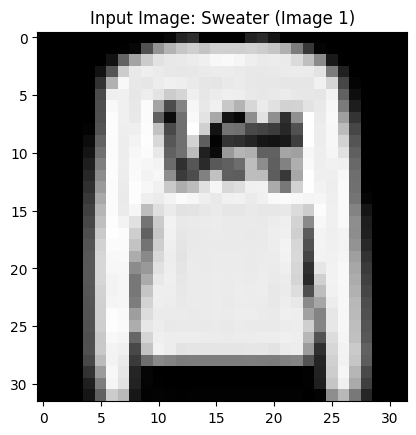

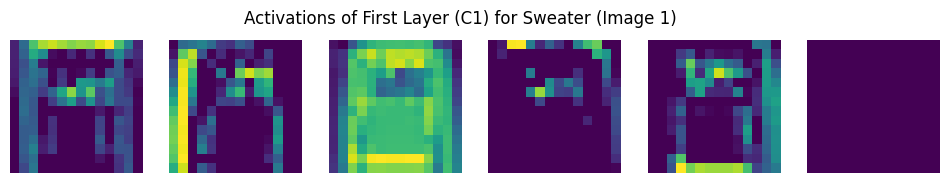

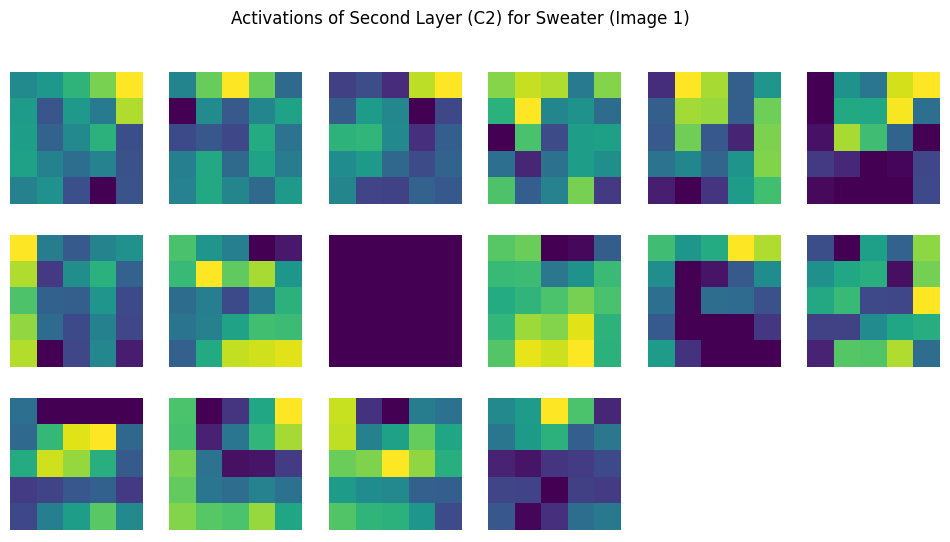

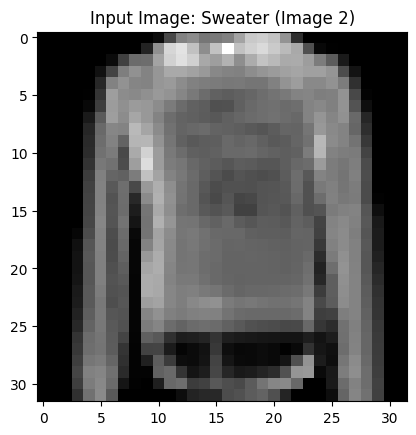

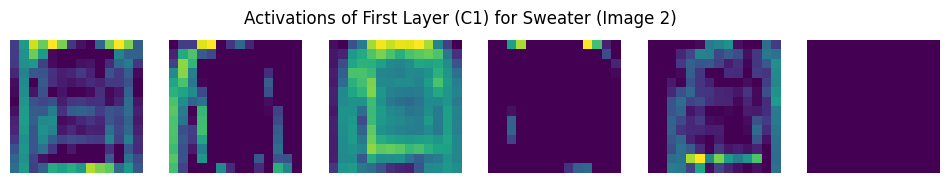

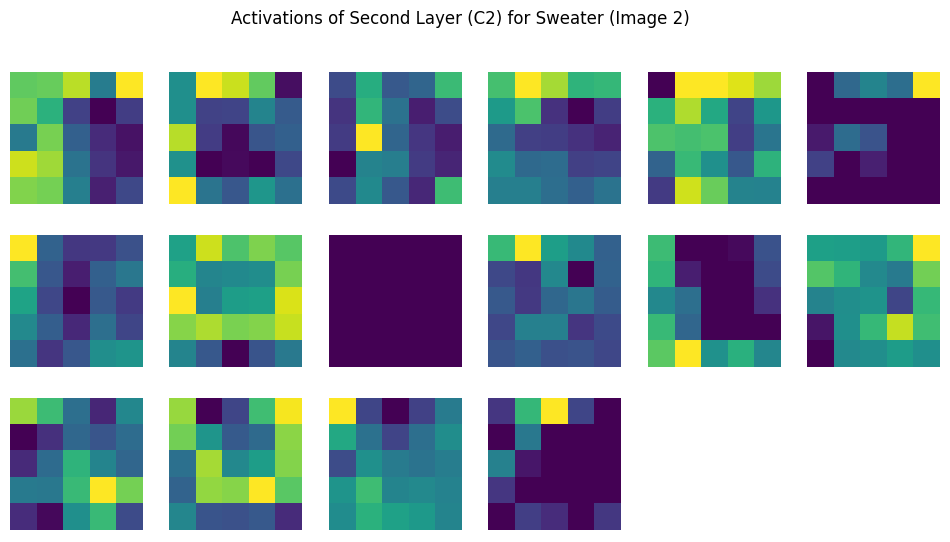

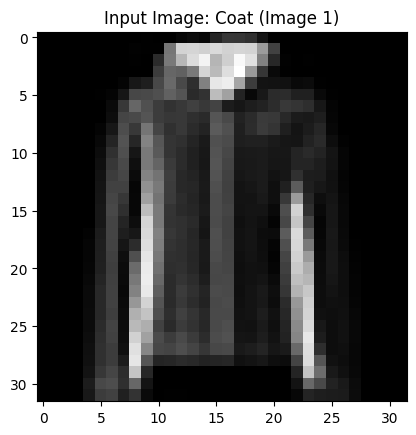

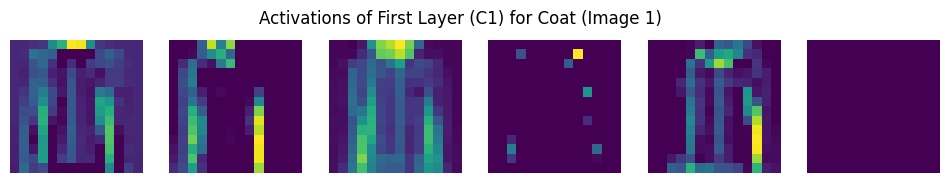

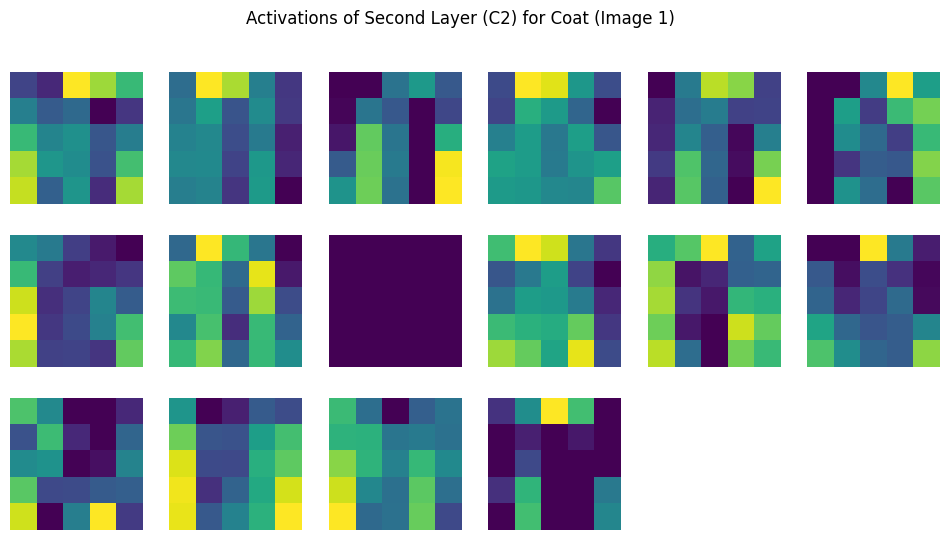

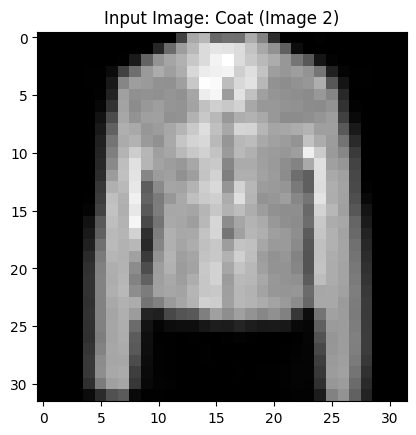

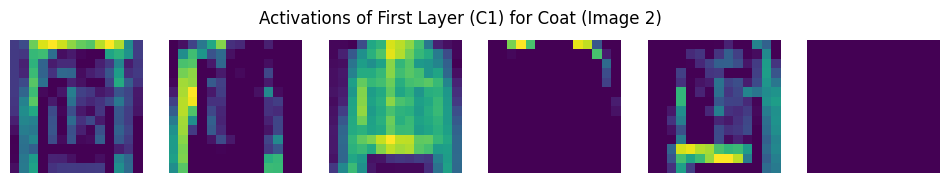

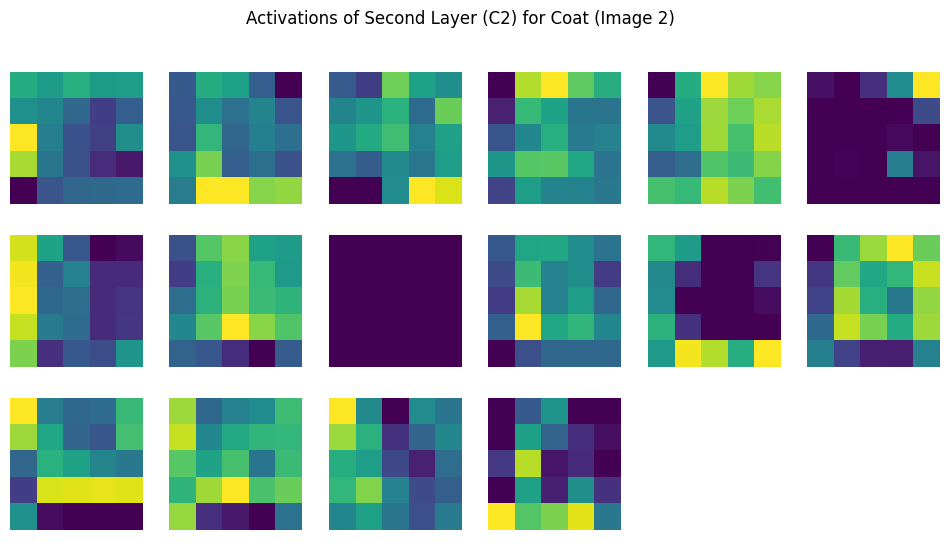

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt

# Helper function to visualize activations
def plot_activations(activation, title):
    num_filters = activation.shape[1]  # Number of channels/filters
    num_cols = 6  # Choose the number of columns to display
    num_rows = (num_filters + num_cols - 1) // num_cols  # Calculate the number of rows dynamically

    # Adjust for small number of filters
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 2))

    # Flatten axes for simpler 1D indexing
    axes = axes.flatten()

    for i in range(num_filters):
        axes[i].imshow(activation[0, i].cpu().detach().numpy(), cmap='viridis')
        axes[i].axis('off')

    # Turn off any extra subplots
    for i in range(num_filters, len(axes)):
        axes[i].axis('off')

    fig.suptitle(title)
    plt.show()

# Define the layers used in LeNet5
class C1(nn.Module):
    def __init__(self):
        super(C1, self).__init__()
        self.c1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=(5, 5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )

    def forward(self, img):
        return self.c1(img)

class C2(nn.Module):
    def __init__(self):
        super(C2, self).__init__()
        self.c2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=(5, 5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )

    def forward(self, img):
        return self.c2(img)

class C3(nn.Module):
    def __init__(self):
        super(C3, self).__init__()
        self.c3 = nn.Sequential(
            nn.Conv2d(16, 120, kernel_size=(5, 5)),
            nn.ReLU()
        )

    def forward(self, img):
        return self.c3(img)

class F4(nn.Module):
    def __init__(self):
        super(F4, self).__init__()
        self.f4 = nn.Sequential(
            nn.Linear(120, 84),
            nn.ReLU()
        )

    def forward(self, img):
        return self.f4(img)

class F5(nn.Module):
    def __init__(self):
        super(F5, self).__init__()
        self.f5 = nn.Sequential(
            nn.Linear(84, 10),
            nn.ReLU()  # Replacing Softmax with ReLU
        )

    def forward(self, img):
        return self.f5(img)

# Modify the LeNet5 class to get activations from layers
class LeNet5_Activations(nn.Module):
    def __init__(self):
        super(LeNet5_Activations, self).__init__()
        self.c1 = C1()
        self.c2 = C2()
        self.c3 = C3()
        self.f4 = F4()
        self.f5 = F5()

    def forward(self, img):
        activation_c1 = self.c1(img)
        activation_c2 = self.c2(activation_c1)
        output = self.c3(activation_c2)
        output = output.view(img.size(0), -1)
        output = self.f4(output)
        output = self.f5(output)
        return output, activation_c1, activation_c2

# Load the Fashion-MNIST dataset
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])

train_dataset = FashionMNIST('./data/fashion-mnist', train=True, download=True, transform=transform)
test_dataset = FashionMNIST('./data/fashion-mnist', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reinitialize the model to extract activations
net_with_activations = LeNet5_Activations().to(device)

# Define a function to visualize activations for specific classes (e.g., sweaters and coats)
def visualize_activations_for_class(class_idx, class_name):
    # Get images and labels of the specified class from the dataset
    images, labels = [], []
    for i, (img, label) in enumerate(test_dataset):
        if label == class_idx:  # Class index for sweaters/coats
            images.append(img.unsqueeze(0))  # Add batch dimension
            labels.append(label)
        if len(images) >= 2:  # Visualize for the first 2 images
            break

    # Send the images to the model and capture activations
    for i, img in enumerate(images):
        img = img.to(device)
        output, activation_c1, activation_c2 = net_with_activations(img)

        # Display the input image
        plt.imshow(img.cpu().squeeze(), cmap='gray')
        plt.title(f"Input Image: {class_name} (Image {i+1})")
        plt.show()

        # Display activations for the first and second layers
        plot_activations(activation_c1, f'Activations of First Layer (C1) for {class_name} (Image {i+1})')
        plot_activations(activation_c2, f'Activations of Second Layer (C2) for {class_name} (Image {i+1})')

# Class indices for Fashion-MNIST:
# 0: T-shirt/top, 1: Trouser, 2: Pullover (sweater), 3: Dress, 4: Coat, ...
sweater_class_idx = 2  # Pullover
coat_class_idx = 4     # Coat

# Visualize activations for sweaters
visualize_activations_for_class(sweater_class_idx, "Sweater")

# Visualize activations for coats
visualize_activations_for_class(coat_class_idx, "Coat")


5. What happens to the activations when you feed significantly different images into the network (e.g., cats, cars, or even random noise)? [2 Marks]

Custom image not found. Please provide a valid image path.


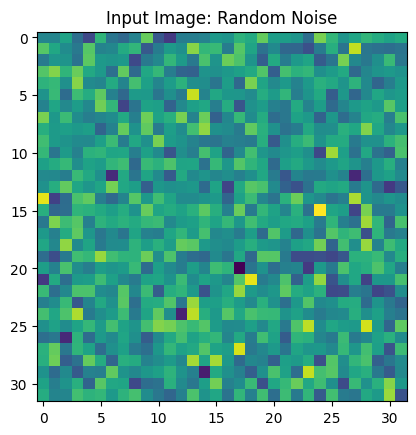

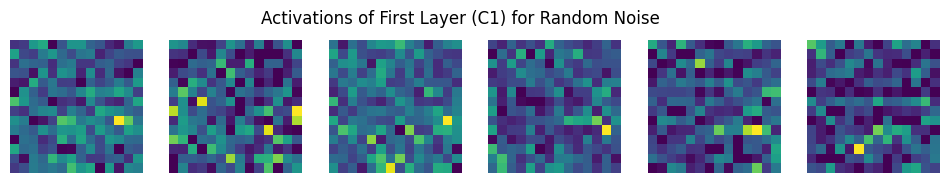

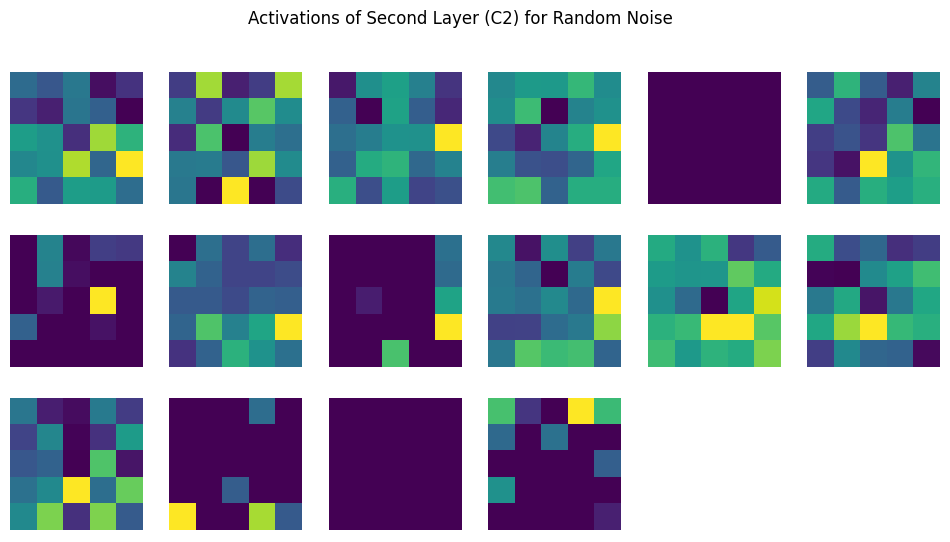

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Helper function to visualize activations
def plot_activations(activation, title):
    num_filters = activation.shape[1]  # Number of channels/filters
    num_cols = 6  # Choose the number of columns to display
    num_rows = (num_filters + num_cols - 1) // num_cols  # Calculate the number of rows dynamically

    # Adjust for small number of filters
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 2))

    # Flatten axes for simpler 1D indexing
    axes = axes.flatten()

    for i in range(num_filters):
        axes[i].imshow(activation[0, i].cpu().detach().numpy(), cmap='viridis')
        axes[i].axis('off')

    # Turn off any extra subplots
    for i in range(num_filters, len(axes)):
        axes[i].axis('off')

    fig.suptitle(title)
    plt.show()

# Define the layers used in LeNet5
class C1(nn.Module):
    def __init__(self):
        super(C1, self).__init__()
        self.c1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=(5, 5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )

    def forward(self, img):
        return self.c1(img)

class C2(nn.Module):
    def __init__(self):
        super(C2, self).__init__()
        self.c2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=(5, 5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )

    def forward(self, img):
        return self.c2(img)

class C3(nn.Module):
    def __init__(self):
        super(C3, self).__init__()
        self.c3 = nn.Sequential(
            nn.Conv2d(16, 120, kernel_size=(5, 5)),
            nn.ReLU()
        )

    def forward(self, img):
        return self.c3(img)

class F4(nn.Module):
    def __init__(self):
        super(F4, self).__init__()
        self.f4 = nn.Sequential(
            nn.Linear(120, 84),
            nn.ReLU()
        )

    def forward(self, img):
        return self.f4(img)

class F5(nn.Module):
    def __init__(self):
        super(F5, self).__init__()
        self.f5 = nn.Sequential(
            nn.Linear(84, 10),
            nn.ReLU()  # Replacing Softmax with ReLU
        )

    def forward(self, img):
        return self.f5(img)

# Modify the LeNet5 class to get activations from layers
class LeNet5_Activations(nn.Module):
    def __init__(self):
        super(LeNet5_Activations, self).__init__()
        self.c1 = C1()
        self.c2 = C2()
        self.c3 = C3()
        self.f4 = F4()
        self.f5 = F5()

    def forward(self, img):
        activation_c1 = self.c1(img)
        activation_c2 = self.c2(activation_c1)
        output = self.c3(activation_c2)
        output = output.view(img.size(0), -1)
        output = self.f4(output)
        output = self.f5(output)
        return output, activation_c1, activation_c2

# Load the Fashion-MNIST dataset
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])

train_dataset = FashionMNIST('./data/fashion-mnist', train=True, download=True, transform=transform)
test_dataset = FashionMNIST('./data/fashion-mnist', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reinitialize the model to extract activations
net_with_activations = LeNet5_Activations().to(device)

# Load a custom image and apply the same preprocessing
def load_custom_image(image_path):
    image = Image.open(image_path).convert('L')  # Convert image to grayscale
    transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Generate random noise and feed it into the model
def load_random_noise():
    noise = torch.randn(1, 1, 32, 32)  # Generate random noise with the same size as the input
    return noise

# Visualize activations for custom inputs (e.g., cats, cars, or random noise)
def visualize_custom_activations(input_tensor, input_name):
    input_tensor = input_tensor.to(device)
    output, activation_c1, activation_c2 = net_with_activations(input_tensor)

    # Display the input image (if it's not random noise)
    if input_name != "Random Noise":
        plt.imshow(input_tensor.cpu().squeeze(), cmap='gray')
    else:
        plt.imshow(input_tensor.cpu().squeeze(), cmap='viridis')
    plt.title(f"Input Image: {input_name}")
    plt.show()

    # Display activations for the first and second layers
    plot_activations(activation_c1, f'Activations of First Layer (C1) for {input_name}')
    plot_activations(activation_c2, f'Activations of Second Layer (C2) for {input_name}')

# Test the model with custom images and random noise
try:
    # Load a custom image (e.g., cat or car) and visualize activations
    custom_img_path = 'path_to_custom_image.jpg'  # Replace with actual path to a cat/car image
    custom_img = load_custom_image(custom_img_path).to(device)
    visualize_custom_activations(custom_img, "Custom Image (Cat/Car)")
except FileNotFoundError:
    print("Custom image not found. Please provide a valid image path.")

# Visualize activations for random noise
random_noise = load_random_noise().to(device)
visualize_custom_activations(random_noise, "Random Noise")
